Autor: Mateusz Markiewicz  
25/05/2020  
Na potrzeby: Seminarium: Algorytmy numeryczne i graficzne

In [ ]:
# Imports
%matplotlib inline

import os
import time
import httpimport
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import scipy.stats as sstats
import math
from sklearn import (decomposition, ensemble, manifold, random_projection)
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn import datasets
import cvxopt
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.metrics.pairwise import rbf_kernel
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.datasets
from IPython.display import clear_output
from tqdm.auto import tqdm


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Czym jest rozpoznawanie i klasyfikacja obrazów

## Klasyfikacja (Image Classification)

Klasyfikacja to przypisanie danym wejściowym etykiet / klas.  

<p align="center">
<img width="617" height="347" src="https://miro.medium.com/max/1400/1*oB3S5yHHhvougJkPXuc8og.gif">
</p>

(Źródło - https://becominghuman.ai/building-an-image-classifier-using-deep-learning-in-python-totally-from-a-beginners-perspective-be8dbaf22dd8)

Dysponujemy skończonym zbiorem etykiet i chcemy dla każdego elementu (np. zdjęcia), który otrzymujemy na wejściu zwrócić jedną z tych etykiet. 

<p align="center">
<img width="617" height="347" src="https://miro.medium.com/max/1400/1*hCxU4nK6ulpnwhSpgWiPPg.png">
</p>


(Źródło - https://medium.com/@tifa2up/image-classification-using-deep-neural-networks-a-beginner-friendly-approach-using-tensorflow-94b0a090ccd4)











## Rozpoznawanie (Image Recognition)

Rozpoznawanie obrazów to proces polegający na rozpoznaniu na zdjęciu określonych osób, zwierząt, obiektów lub przedmiotów. Przykładem jest proces rozpoznania twarzy.
Przykładem rozpoznawania obrazów jest rozpoznawanie twarzy, algorytm musi poradzić sobie z sytuacją, w której twarz nie znajduje się idealnie po środku, musi więc ją wykryć, a następnie sklasyfikować, czy należy do właściciela telefonu. 

<p align="center">
<img width="670" height="550" src="https://i.imgur.com/z9BzidL.png">
</p>

(Źródło - http://hskinternational.com/AI_Experiments/object_classification_detection/)

## Wykrywanie (Image Detection)

To proces polegający na oznaczeniu na obrazie osób / zwierząt / przedmiotów. Często algorytmy poza oznaczeniem gdzie znajdują się poszczególne obiekty klasyfikuje je.

<p align="center">
<img width="681" height="347" src="https://cdn.filestackcontent.com/PyosrcISSROz1ON9zxhr">
</p>

(Źródło - https://hackernoon.com/introductory-guide-to-real-time-object-detection-with-python-6jyb36t5)

## Co nam będzie potrzebne? 

Wszystkie wyżej wymienione problemy są częścią uczenia nadzorowanego (supervised learning). Oznacza to, że w procesie uczenia dysponujemy danymi, które są poprawnie zaklasyfikowane, przez co sam proces uczenia może być nadzorowany. Mając dany model wiemy, jak dobrze radzi sobie on na danych, którymi dysponujemy i w oparciu o to, możemy go poprawić.




### Data sets

Będziemy więc potrzebowali zbioru danych z poprawnie przypisanymi klasami.  
Chcąc stworzyć model do rozpoznawania ręcznie zapisanych cyfr potrzebujemy przykładowych danych. Wiele takich zbiorów danych jest dostępnych w internecie, przykładowo najpopularniejszym zbiorem do opisanego wyżej zadania jest Mnist.

In [ ]:
!pip install -q gdown httpimport
![ -e mnist.npz ] || gdown 'https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU' -O mnist.npz

Downloading...
From: https://drive.google.com/uc?id=1QPaC3IKB_5tX6yIZgRgkpcqFrfVqPTXU
To: /content/mnist.npz
55.4MB [00:00, 77.6MB/s]


In [ ]:
# 70 000 danych
with np.load('mnist.npz') as data:
    mnist_full_train_data_uint8 = data['train_data']
    mnist_full_train_labels_int64 = data['train_labels']
    mnist_test_data_uint8 = data['test_data']
    mnist_test_labels_int64 = data['test_labels']

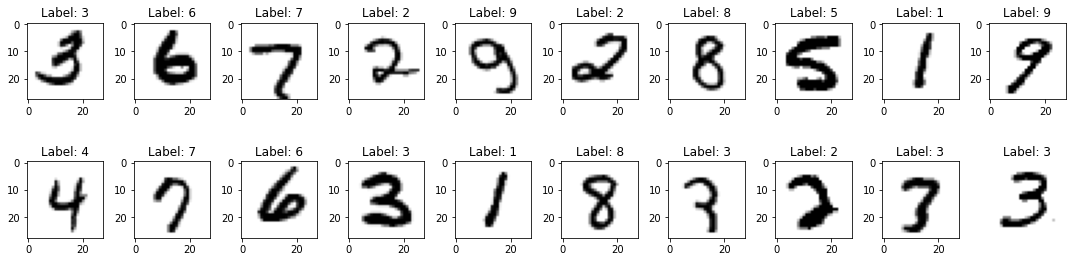

In [ ]:
fig, ax = plt.subplots(2,10,figsize=(15,4))
for i, ax in enumerate(ax.flatten()):
    idx = np.random.randint(0,60000)
    ax.set_title(f'Label: {mnist_full_train_labels_int64[idx]}')
    ax.imshow(mnist_full_train_data_uint8[idx], cmap='gray_r')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Train-test split

Nie możemy jednak używać całych danych, którymi dysponujemy do nauki. 

**Naszym celem jest, by nasz model radził sobie dobrze z danymi, których nigdy wcześniej nie widział.**

Jeśli w procesie uczenia będziemy oceniać skuteczność modelu na podstawie tych samych danych, na których ten model się uczył, to pomiar ten nie będzie wiarygodny. W skrajnych przypadkach model może zapamiętać klasy wszystkich danych, na których go uczymy, uzyskując 100% skuteczności, pomimo że najprawdopodobniej nie poradzi sobie z danymi, których nigdy nie widział. Jak sobie z tym poradzić?

<p align="center">
<img width="460" height="300" src="https://i.stack.imgur.com/pXAfX.png">
</p>
(Źródło - https://datascience.stackexchange.com/questions/61467/clarification-on-train-test-and-val-and-how-to-use-implement-it)

Dzielimy nasze dane na dane treningowe, na których uczymy nasz model oraz dane testowe, na których będziemy go testować.  

Jeśli nasz model ma dodatkowe parametry taki podział może być niewystarczający, wówczas dzielimy dane na 3 części: treningową, walidacyjną oraz testową. Częśc walidacyjna będzie nam służyła do ustalenia najlepszych parametrów naszego modelu. 

Czasem używa się innego podziału danych, np. Cross-Validation

<p align="center">
<img width="770" height="300" src="https://miro.medium.com/max/2984/1*pJ5jQHPfHDyuJa4-7LR11Q.png">
</p>
(Źródło - https://medium.com/@hi.martinez/train-test-split-cross-validation-you-b87f662445e1)



In [ ]:
mnist_train_data_uint8 = mnist_full_train_data_uint8[:50000]
mnist_train_labels_int64 = mnist_full_train_labels_int64[:50000]
mnist_valid_data_uint8 = mnist_full_train_data_uint8[50000:]
mnist_valid_labels_int64 = mnist_full_train_labels_int64[50000:]

# KNN (K-nearest neighbors)

Pierwszym podejściem do problemu klasyfikacji będzie algorytm KNN. Idea algorytmu jest bardzo prosta. Dla obrazka, który dostajemy do sklasyfikowania znajdujemy K najbliższych mu obrazków z danych treningowych oraz zwracamy najczęstszą spośród ich klas.  

Co oznacza najbliższych w kontekście obrazów?
Obraz jest macierzą, której każdym element reprezentuje pojedynczy piksel. W przypadku MNIST piksele są w skali szarości, więc każdy reprezentowany jest jako pojedyncza wartość. Możemy rozwinąć macierz w wektor, a następnie mając dwa takie wektory obliczamy drugą normę ich różnicy, a więc wartość:

$$ dist(X^i,Y^j) = \sqrt{ \sum_{k=0}^{K} (X_k^i-Y_k^j)^2} $$

gdzie $X^i$ to $i$-ty wektor spośród danych treningowych, a $Y^j$ to $j$-ty wektor spośród danych testowych.

Dla każdego wektora, któremu chcemy przyporządkować klasę potrzebujemy jego odległość do wszystkich danych treningowych, czyli macierzy D, takiej że 
$$D_{i,j} = Dist(X^i,Y^j)$$

Potrzebujemy metody na szybkie obliczanie takiej macierzy.  
Pierwszą obserwacją jest to, że nie potrzebujemy obliczać pierwiastka, ponieważ interesuje nas jedynie wyznaczenie K najbliższych wektorów, nie potrzebujemy znać dokładnej odległości do tych wektorów. Następnie możemy zauważyć, że:

$$\sum_{k=0}^{K} (X_k^i-Y_k^j)^2 =  \sum_{k=0}^{K} (X_k^i)^2 + \sum_{k=0}^{K} (Y_k^j)^2 - 2*(Y^j)^T*X^i$$


Mając taką postać możemy pominąć wyrażenie $\sum_{k=0}^{K} (Y_k^j)^2$, ponieważ jest ono takie same dla odległości do dowolnego wektora z danych treningowych.  
Taka postać wyrażenie wykorzystujemy do obliczenia całej macierzy D w tym samym czasie za pomocą wyrażenia:
$$\sum_{k=0}^{K} X_k^2 - 2  Y  X^T$$


In [ ]:
def err_rates(preds, test_Y):
    ret = {}
    for k, preds_k in  preds.items():
        ret[k] = np.sum(preds_k != test_Y)/test_Y.shape[0]
    return ret

In [ ]:
def KNN(train_X, train_Y, test_X, ks, verbose=False):
    """
    Compute predictions for various k
    Args:
        train_X: array of shape Ntrain x D
        train_Y: array of shape Ntrain
        test_X: array of shape Ntest x D
        ks: list of integers
    Returns:
        preds: dict k: predictions for k
    """
    # Cats data to float32
    train_X = train_X.astype(np.float32)
    test_X = test_X.astype(np.float32)

    # Alloc space for results
    preds = {}

    if verbose:
        print("Computing distances... ", end='')

    dists = -2 * np.dot(test_X, train_X.T) + np.sum(train_X**2,axis=1)
    
    if verbose:
        print("Sorting... ", end='')
    
    closest = dists.argsort()

    if verbose:
        print("Computing predictions...", end='')
    
    targets = train_Y[closest]

    for k in ks:
        predictions = sstats.mode(targets[:,:k],axis=1)[0]
        predictions = predictions.ravel()
        preds[k] = predictions
    if verbose:
        print("Done")
    return preds

# Funkcja KNN pochodzi z ćwiczeń z Machine Learningu

In [ ]:
def batched_KNN(train_X, train_Y, test_X, ks, verbose=False, batch_size=200):
    all_preds = {k: [] for k in ks}
    for i in range(0, test_X.shape[0], batch_size):
        batch_X = test_X[i:i + batch_size]
        if verbose:
            print(f"Processing batch {i}:{i + batch_X.shape[0]}... ", end='')
        preds = KNN(train_X,train_Y,batch_X,ks,verbose)
        for k in all_preds.keys():
            all_preds[k] = np.concatenate((all_preds[k],preds[k]),axis = 0)
    return all_preds

Processing batch 0:200... Computing distances... Sorting... Computing predictions...Done
Processing batch 200:400... Computing distances... Sorting... Computing predictions...Done
Processing batch 400:600... Computing distances... Sorting... Computing predictions...Done
Processing batch 600:800... Computing distances... Sorting... Computing predictions...Done
Processing batch 800:1000... Computing distances... Sorting... Computing predictions...Done
Processing batch 1000:1200... Computing distances... Sorting... Computing predictions...Done
Processing batch 1200:1400... Computing distances... Sorting... Computing predictions...Done
Processing batch 1400:1600... Computing distances... Sorting... Computing predictions...Done
Processing batch 1600:1800... Computing distances... Sorting... Computing predictions...Done
Processing batch 1800:2000... Computing distances... Sorting... Computing predictions...Done
Processing batch 2000:2200... Computing distances... Sorting... Computing predict

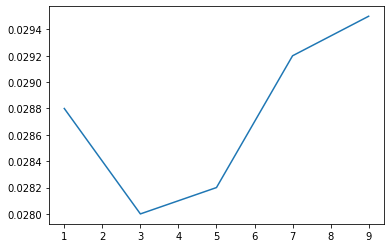

In [ ]:
# finding the best k on the validation set
ks = [1, 3, 5, 7, 9]
mnist_validation_preds = batched_KNN(
    mnist_train_data_uint8.astype('float32').reshape(-1, 28*28), mnist_train_labels_int64,
    mnist_valid_data_uint8.astype('float32').reshape(-1, 28*28),
    ks, verbose=True)

mnist_validation_errs = err_rates(mnist_validation_preds, mnist_valid_labels_int64)
plt.plot(ks, [mnist_validation_errs[k] for k in ks])

In [ ]:
best_K = 3

mnist_test_preds = batched_KNN(
    mnist_full_train_data_uint8.astype('float32').reshape(-1, 28*28), 
    mnist_full_train_labels_int64,
    mnist_test_data_uint8.astype('float32').reshape(-1, 28*28), 
    [best_K], verbose=True)

mnist_test_errs = err_rates(mnist_test_preds, mnist_test_labels_int64)
print(f"\n\nWhen k={best_K} the test error rate is {mnist_test_errs[best_K] * 100.0:.1f}%")

Processing batch 0:200... Computing distances... Sorting... Computing predictions...Done
Processing batch 200:400... Computing distances... Sorting... Computing predictions...Done
Processing batch 400:600... Computing distances... Sorting... Computing predictions...Done
Processing batch 600:800... Computing distances... Sorting... Computing predictions...Done
Processing batch 800:1000... Computing distances... Sorting... Computing predictions...Done
Processing batch 1000:1200... Computing distances... Sorting... Computing predictions...Done
Processing batch 1200:1400... Computing distances... Sorting... Computing predictions...Done
Processing batch 1400:1600... Computing distances... Sorting... Computing predictions...Done
Processing batch 1600:1800... Computing distances... Sorting... Computing predictions...Done
Processing batch 1800:2000... Computing distances... Sorting... Computing predictions...Done
Processing batch 2000:2200... Computing distances... Sorting... Computing predict

In [ ]:
confusion_matrix(mnist_test_labels_int64,mnist_test_preds[3])

array([[ 974,    1,    1,    0,    0,    1,    2,    1,    0,    0],
       [   0, 1133,    2,    0,    0,    0,    0,    0,    0,    0],
       [  10,    9,  996,    2,    0,    0,    0,   13,    2,    0],
       [   0,    2,    4,  976,    1,   13,    1,    7,    3,    3],
       [   1,    6,    0,    0,  950,    0,    4,    2,    0,   19],
       [   6,    1,    0,   11,    2,  859,    5,    1,    3,    4],
       [   5,    3,    0,    0,    3,    3,  944,    0,    0,    0],
       [   0,   21,    5,    0,    1,    0,    0,  991,    0,   10],
       [   8,    2,    4,   16,    8,   11,    3,    4,  914,    4],
       [   4,    5,    2,    8,    9,    2,    1,    8,    2,  968]])

Następnie możemy obejrzeć jak to działa.

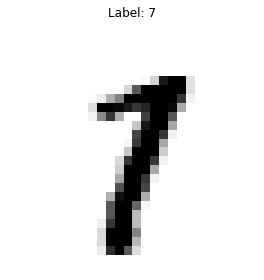

In [ ]:
# Wylosujmy jedną liczbę z danych testowych:
# 247 daje ciekawy wynik
idx = np.random.randint(0,10000)
test_sample = mnist_test_data_uint8.astype('float32')[idx]
test_sample_label = mnist_test_labels_int64[idx]
plt.title(f'Label: {test_sample_label}')
plt.imshow(test_sample, cmap='gray_r')
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Wyznaczamy odległość do każdego wektora danych treningowych oraz sortujemy je (pamiętamy indexy)
train_X = mnist_train_data_uint8.astype('float32').reshape(-1, 28*28)
train_Y = mnist_train_labels_int64
test_X = np.array([test_sample]).reshape(-1, 28*28)
dists = -2 * np.dot(test_X, train_X.T) + np.sum(train_X**2,axis=1)
closest = dists.argsort().ravel()

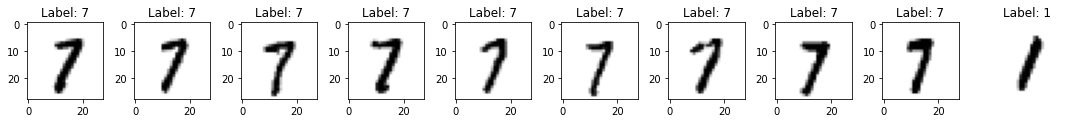

In [ ]:
fig, ax = plt.subplots(1,10,figsize=(15,2))
for i, ax in enumerate(ax.flatten()):
    idx = closest[i]
    ax.set_title(f'Label: {mnist_full_train_labels_int64[idx]}')
    ax.imshow(mnist_full_train_data_uint8[idx], cmap='gray_r')
    plt.axis('off')
plt.tight_layout()
plt.show()

Następnie zwracamy najczęstszą spośród klas najbliższych wektorów z danych treningowych.

In [ ]:
sstats.mode(mnist_full_train_labels_int64[closest[:10]])[0][0]

8

## Inne zastosowania KNN

Inpainting

<p align="center">
<img width="600" height="600" src="https://i.imgur.com/5g0VtGm.png">
</p>

## Redukcja wymiarowości

Aktualnie nasze wektory mają 784 (28*28) wymiarów. W niektórych sytuacjach będziemy chcieli przedstawić te wektory w przestrzeni mniej wymiarowej. Przykładem może być konieczność wizualizacji tych danych, ale takie działanie może również poprawić skuteczność oraz prędkość działania klasyfikatora.

In [ ]:
def plot_digits(X, y):
    X = (X - np.min(X, 0)) / (np.max(X, 0) - np.min(X, 0))
    plt.figure(figsize=(12, 9))
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]), color=plt.cm.Set1(0.1*y[i]), fontdict={'weight':'bold', 'size':8})
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
X = train_X[:1000]
Y = train_Y[:1000]

### Random projection

Wybieranie n losowych wymiarów.

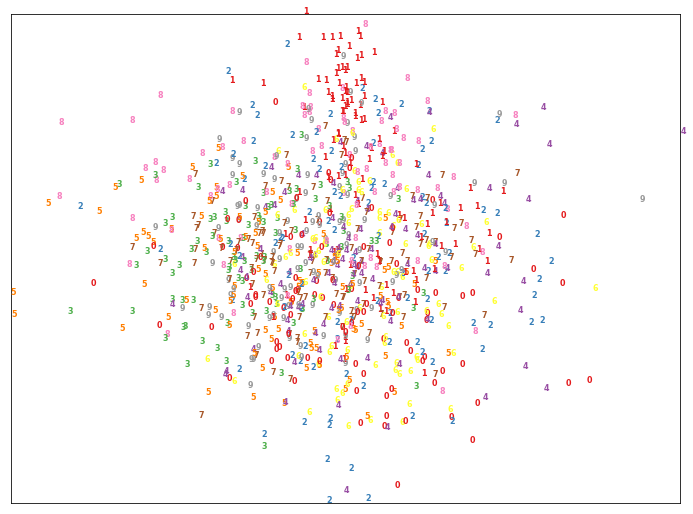

In [ ]:
X_projected = random_projection.SparseRandomProjection(n_components=2).fit_transform(X)
plot_digits(X_projected, Y)

### PCA

Principal component analysis - analiza głównych składowych. Wyznacza nowe, nieskorelowane współrzędne tak, by maksymalizowały wariancję danych.

<p align="center">
<img width="1000" height="400" src="https://media1.giphy.com/media/Lyejb62QjQepG/source.gif">
</p>

(Źródło - https://giphy.com/gifs/pca-Lyejb62QjQepG)

Szczegóły - http://cs229.stanford.edu/notes/cs229-notes10.pdf


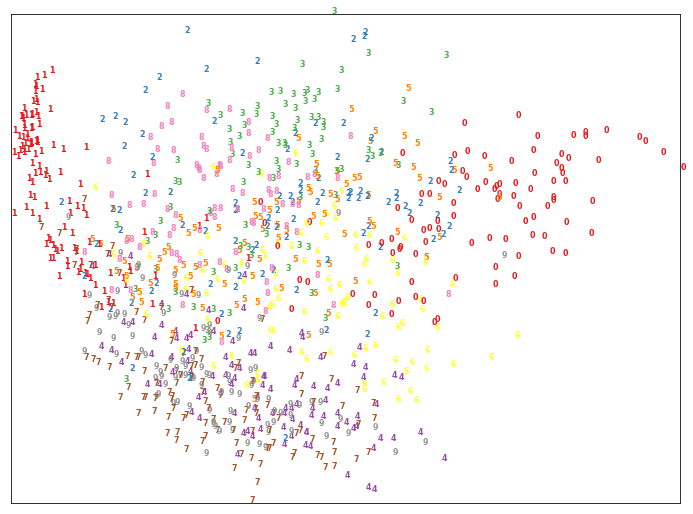

In [ ]:
X_pca = decomposition.PCA(n_components=2,whiten=True).fit_transform(X)
plot_digits(X_pca, Y)

### K-PCA

Kernel principal component analysis. Od PCA różni się tym, że najpierw zwiększamy wymiarowość danych poprzez zastosowanie kernelizacji, a następnie stosujemy analizę składowych głównych.

<p align="center">
<img width="728" height="373" src="https://i.imgur.com/U0rtyPT.png">
</p>

(Źródło - https://rpubs.com/sandipan/197468)




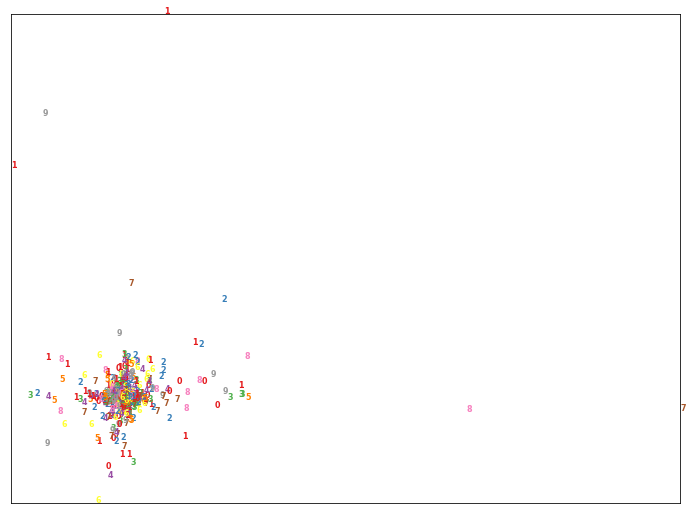

In [ ]:
X_kpca = decomposition.KernelPCA(n_components=2, kernel="rbf", gamma=10).fit_transform(X)
plot_digits(X_kpca, Y)

### Isomap

Isomap dla każdego punktu wyznacza jego k najbliższych sąsiadów, następnie tworzy ich graf oraz zapamiętuje w nim najkrótsze ścieżki pomiędzy każdymi dwoma wierzchołkami. Mając takie dane próbujemy znaleźć takie punkty, które jak najlepiej odwzorowują te informacje w mniej wymiarowej przestrzeni. 

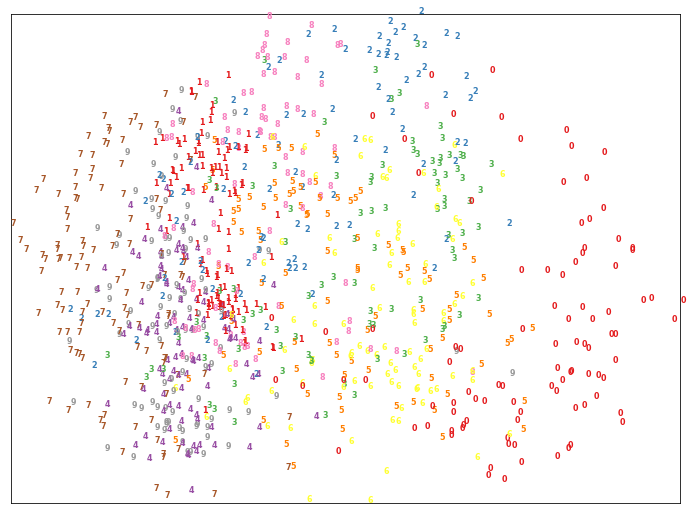

In [ ]:
X_iso = manifold.Isomap(20, n_components=2).fit_transform(X)
plot_digits(X_iso, Y)

### LLE

Locally Linear Embedding. Algorytm polega na wyznaczeniu k najbliższych sąsiadów, następnie znalezieniu wag pozwalających jak najlepiej przybliżyć dany punkt jako liniową kombinację jego najbliższych sąsiadów wraz z tymi wagami, tj.
$$ x_i \approx \sum_{k=0}^K x_k * w_{ik}$$

Następnie staramy się znaleźć takie punkty w przestrzeni mniej wymiarowej, że każdy punkt jest jak najlepiej opisany za pomocą wcześniej uzyskanych wag, tj.
$$ y_i \approx \sum_{k=0}^K y_k * w_{ik}$$

<p align="center">
<img width="440" height="440" src="https://miro.medium.com/max/878/0*dey-qDexfQvENUrl.gif">
</p>


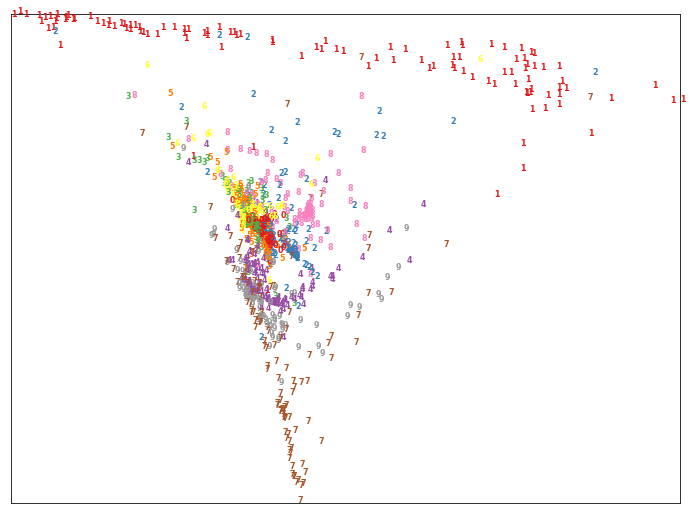

In [ ]:
X_lle = manifold.LocallyLinearEmbedding(12, n_components=2).fit_transform(X)
plot_digits(X_lle, Y)

### MDS

Multidimensional scaling. Algorytm polega na wyznaczeniu macierzy odległości pomiędzy każdą parą punktów, a następnie stara się znaleźć takie punkty w przestrzeni mniej wymiarowej, że ich macierz odległości jest jak najbardziej zbliżona do tej oryginalnej. 

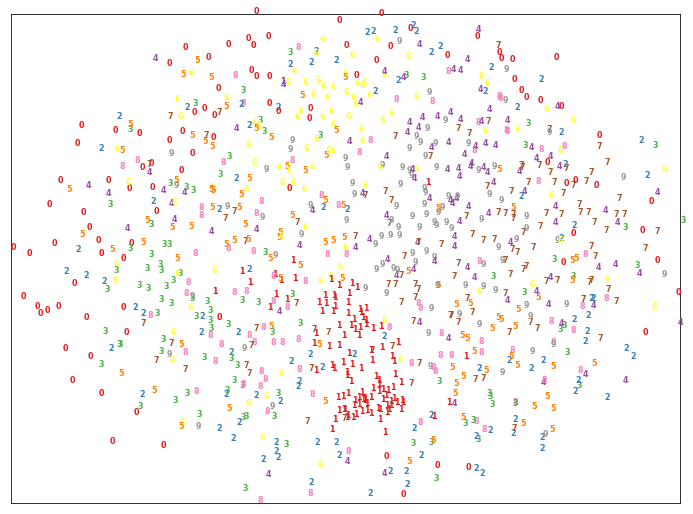

In [ ]:
X_mds = manifold.MDS(n_components=2, n_init=1, max_iter=100, metric=True).fit_transform(X)
plot_digits(X_mds, Y)

### t-SNE

T-distributed Stochastic Neighbor Embedding. Znając podobieństwa par punktów możemy wyznaczyć prawdopodobieństwo znalezienia się blisko siebie dla każdej pary punktów. Następnie staramy się znaleźć punkty w przestrzeni mniej wymiarowej, które jak najlepiej realizują takie prawdopodobieństwa.


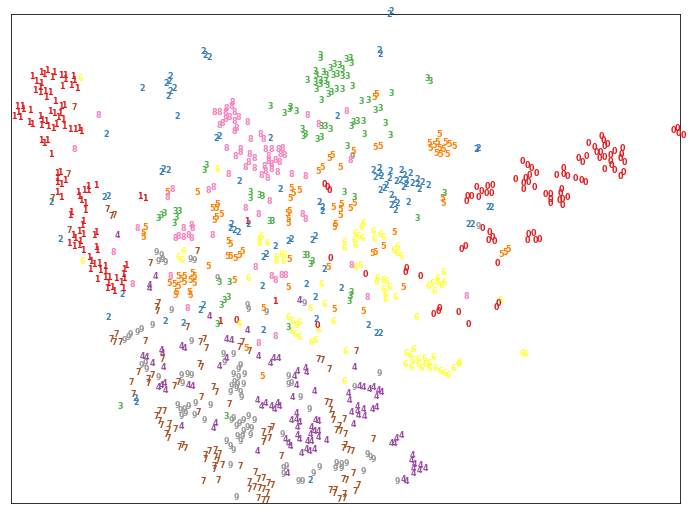

In [ ]:
X_tsne = manifold.TSNE(n_components=2, init='pca', perplexity=10).fit_transform(X)
plot_digits(X_tsne, Y)

**Uwaga:**
MDS oraz t-SNE służą głównie do wizualizacji. W przeciwieństwie do pozostałych metod nie pozwalają one na wyznaczeniu odpowiedniego przekształcenia tylko za pomocą danych treningowych, a następnie zastosowaniu go również do danych testowych. Uniemożliwia to użycie tych metod do klasyfikacji, ponieważ chcąc wyznaczyć klasę nowego wektora musielibyśmy wyznaczać nową redukcję wymiarowości i szkolić cały model na podstawie tak zredukowanych danych treningowych. 

## KNN + PCA

Sprawdźmy więc, jaki błąd uzyskamy jeśli ograniczymy wymiarowość naszych danych przed zastosowaniem KNN.

In [ ]:
Ks = [2,3,5,10,20,30,40,50,75,100,125,150,200,250,350,500]
res_ = []

In [ ]:
for K in Ks:
    PCA = decomposition.PCA(n_components=K,whiten=True)
    pca_train = PCA.fit_transform(train_X)
    valid_X = mnist_valid_data_uint8.astype('float32').reshape(-1, 28*28)
    test_X = mnist_test_data_uint8.astype('float32').reshape(-1, 28*28)
    pca_valid = PCA.transform(valid_X)
    pca_test = PCA.transform(test_X)
    ks = [5]
    mnist_validation_preds = batched_KNN(
        pca_train, mnist_train_labels_int64,
        pca_valid,
        ks, verbose=False)
    mnist_validation_errs = err_rates(mnist_validation_preds, mnist_valid_labels_int64)
    res_.append(mnist_validation_errs[ks[0]])


Text(0.5, 1.0, 'Skutecznść KNN (dla K=5) wraz z PCA z n składowymi')

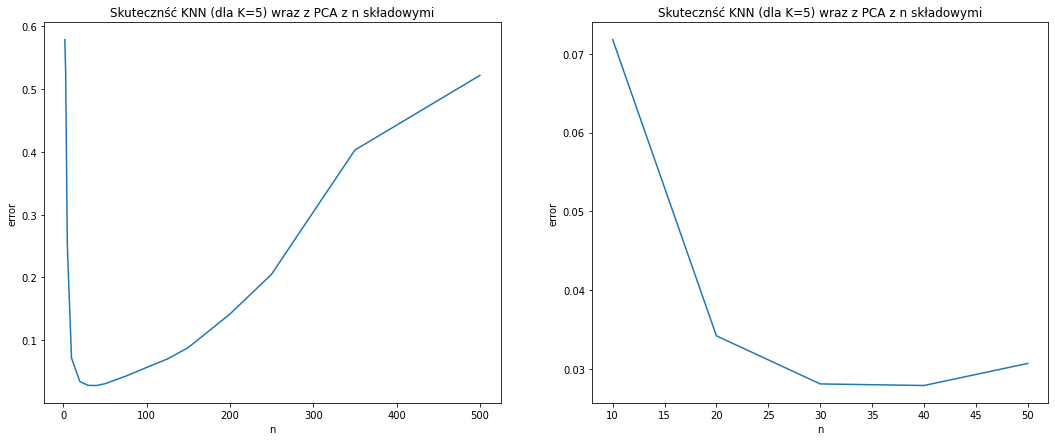

In [ ]:
f,ax = plt.subplots(1,2,figsize=(18,7))
ax[0].plot(Ks,res_)
ax[0].set_xlabel('n')
ax[0].set_ylabel('error')
ax[0].set_title('Skutecznść KNN (dla K=5) wraz z PCA z n składowymi')
ax[1].plot(Ks[3:8],res_[3:8])
ax[1].set_xlabel('n')
ax[1].set_ylabel('error')
ax[1].set_title('Skutecznść KNN (dla K=5) wraz z PCA z n składowymi')

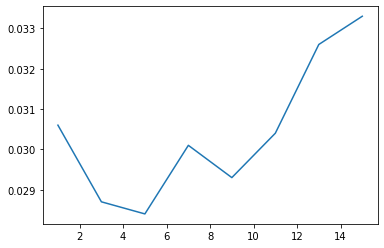

In [ ]:
PCA = decomposition.PCA(n_components=40,whiten=True)
pca_train = PCA.fit_transform(train_X)
valid_X = mnist_valid_data_uint8.astype('float32').reshape(-1, 28*28)
test_X = mnist_test_data_uint8.astype('float32').reshape(-1, 28*28)
pca_valid = PCA.transform(valid_X)
pca_test = PCA.transform(test_X)
ks = [1,3,5,7,9,11,13,15]
mnist_validation_preds = batched_KNN(
    pca_train, mnist_train_labels_int64,
    pca_valid,
    ks, verbose=False)
mnist_validation_errs = err_rates(mnist_validation_preds, mnist_valid_labels_int64)
plt.plot(ks, [mnist_validation_errs[k] for k in ks])

In [ ]:
pca_test.shape

(10000, 40)

In [ ]:
best_K = 5

mnist_test_preds = batched_KNN(
    pca_train, mnist_train_labels_int64,
    pca_test,
    [best_K], verbose=True)

mnist_test_errs = err_rates(mnist_test_preds, mnist_test_labels_int64)
print(f"\n\nWhen k={best_K} the test error rate is {mnist_test_errs[best_K] * 100.0:.1f}%")

Processing batch 0:200... Computing distances... Sorting... Computing predictions...Done
Processing batch 200:400... Computing distances... Sorting... Computing predictions...Done
Processing batch 400:600... Computing distances... Sorting... Computing predictions...Done
Processing batch 600:800... Computing distances... Sorting... Computing predictions...Done
Processing batch 800:1000... Computing distances... Sorting... Computing predictions...Done
Processing batch 1000:1200... Computing distances... Sorting... Computing predictions...Done
Processing batch 1200:1400... Computing distances... Sorting... Computing predictions...Done
Processing batch 1400:1600... Computing distances... Sorting... Computing predictions...Done
Processing batch 1600:1800... Computing distances... Sorting... Computing predictions...Done
Processing batch 1800:2000... Computing distances... Sorting... Computing predictions...Done
Processing batch 2000:2200... Computing distances... Sorting... Computing predict

In [ ]:
confusion_matrix(mnist_test_labels_int64,mnist_test_preds[5])

array([[ 973,    1,    1,    0,    0,    1,    2,    2,    0,    0],
       [   0, 1129,    3,    1,    0,    0,    1,    0,    0,    1],
       [  11,    8,  985,    4,    1,    0,    3,   16,    4,    0],
       [   3,    0,    2,  975,    2,   13,    0,    9,    4,    2],
       [   2,   11,    2,    0,  940,    0,    4,    2,    1,   20],
       [   4,    0,    1,   14,    4,  859,    4,    2,    2,    2],
       [   6,    3,    0,    0,    2,    3,  944,    0,    0,    0],
       [   0,   15,    7,    0,    4,    1,    0,  994,    0,    7],
       [   2,    2,    4,   19,    8,   18,    5,    5,  906,    5],
       [   4,    4,    0,    9,   12,    4,    1,    6,    2,  967]])

# SVM

[**SVM tutorial**](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/svmtutorial.pdf)  
[Kernel trick](http://cs229.stanford.edu/notes2019fall/cs229-notes3.pdf)

Niech $X^i$ będzie i-tym wektorem danych (np. rozwiniętą macierzą reprezentującą obraz), a $Y^i$ będzie klasą tego wektora, gdzie $Y \in \{-1,1\}$, mamy więc 2 możliwe klasy.

Celem SVM jest wyznaczenie klasy dla $X^i$ na podstawie $\text{signum}(w^T X^i + b)$. 

Mając zbiór danych testowych $X$ chcemy wyznaczyć odpowiednie wagi $w$ oraz przesunięcie $b$. Dopuszczamy pojedyncze błędy w klasyfikacji danych treningowych, chcemy więc, by:

$$Y^i(w^T X^i + b) \geq 1 - \xi_i $$

Realizujemy to minimalizując następujące równanie:

$$\begin{split}
  \min_{w,b,\xi}  &\frac{1}{2}w^Tw  + C\sum_{i=1}^m \xi_i  \\
  \text{t.że  } & y^{(i)}(w^T x^{(i)} + b) \geq 1- \xi_i\;\; \forall_i \\
  & \xi_i \geq 0 \;\; \forall_i.
\end{split}$$

<p align="center">
<img width="558" height="414" src="https://jeremykun.files.wordpress.com/2017/06/svm_solve_by_hand-e1496076457793.gif?w=558&zoom=2">
</p>

(Źródło - https://jeremykun.com/2017/06/05/formulating-the-support-vector-machine-optimization-problem/)

## Kernel trick

Powyżej sformułowane równanie możemy rozwiązać za pomocą mnożników Lagrangea. $w$ można przedstawić jako liniową kombinację danych treningowych, czyli:

$$w = \sum_{i=0}^I \alpha_i * X^i$$

Gdzie $\alpha_i$ to mnożniki Langrangea.

Następnie możemy zaobserwować, że chcąc wyznaczyć klasę wektora $X^k$ musimy obliczyć

$$f(\textbf{X}) = w^T \textbf{X} + b = \sum_{i=0}^I \alpha_i * (X^i)^T * \textbf{X} + b$$

<p align="center">
<img width="700" height="400" src="https://miro.medium.com/max/872/1*zWzeMGyCc7KvGD9X8lwlnQ.png">
</p>

(Źródło - https://towardsdatascience.com/the-kernel-trick-c98cdbcaeb3f)

Wiemy, że nie wszystkie dane możemy rozdzielić linią. Jeśli przedstawimy je jednak w przestrzeni wyżej wymiarowej może się okazać, że będzie się dało znaleźć linie (w tej wyżej-wymiarowej przestrzeni), która je rozdziela. Chcemy wykorzystać nieliniowe przekształcenie $x \rightarrow \phi(x) $. 
Powyższe równanie sprowadzają się do:

$$w = \sum_{i=0}^I \alpha_i * \phi(X^i)$$

$$f(\textbf{X}) = w^T \phi(\textbf{X}) + b = \sum_{i=0}^I \alpha_i * (\phi(X^i))^T * \phi(\textbf{X}) + b$$

Potrzebujemy więc wartość iloczynu skalarnego obliczonego w przestrzeni $\phi(*)$. Jeśli będziemy znali sposób na szybkie obliczanie iloczynu skalarnego nie będziemy musieli obliczać $\phi(\textbf{X})$. Czy to jest jednak możliwe?

Okazuje się, że są takie nieliniowe przekształcenia $\phi(*)$, dla których jest to możliwe. 

Niech $X$ = $[X_0,X_1]$ oraz $Y$ = $[Y_0,Y_1]$.  
Niech $\phi(X) = [X_0^2,\sqrt2 * X_0 * X_1, X_1^2]$.

Oznaczmy $K(X,Y) = \phi(X)^T \phi(Y)$
Pokażemy, że jesteśmy w stanie obliczyć $K(X,Y)$ wykonując jedynie obliczenia w oryginalnej przestrzeni.  
Niech $K(X,Y) = (X^T Y)^2$, wówczas:

$$\begin{split}
K(X,Y) & = \, & (X^T Y)^2\\
& = \, & (X_0 Y_0 + X_1 Y_1)^2\\
& = \, & (X_0^2 Y_0^2 + 2 X_0 Y_0 X_1 Y_1 + X_1^2 Y_1^2)\\
& = \, & (\phi(X))^T  (\phi(Y))
\end{split}$$

Okazuje się, że takich funkcji jest więcej, najczęściej używane:

Polynomial Kernel:  
$K(X,Y) = (X^T Y + \Theta)^d$

RBF (Radial Basis Function / Gaussian Kernel):  
$K(X,Y) = e^{-\frac{||X-Y||^2}{2\sigma^2}}$


Korzystając z tych obserwacji możemy wykorzystać Kernel trick do SVM. Wówczas równanie, które będziemy chcieli optymalizować w celu odnalezienia najlepszych parametrów przyjmie postać:

$$\begin{aligned}
    \min_{\alpha}  \frac{1}{2}  \alpha^T \mathbf{H}  \alpha - 1^T \alpha
    \\
     s.t.  - \alpha_i \leq 0 
    \\
      \alpha_i \leq C
     \\
     \ y^T \alpha = 0  
     \\ 
     \ H = y^TKy  
     \\
     \ K_{i,j} = K(X^i,X^j)
\end{aligned}$$

Równanie w tej postaci może zostać rozwiązane, np. za pomocą QP-solvera.

## Multi-class SVM

Są dwa główne podejścia, by przystosować wyżej opisany algorytm do radzenia sobie z danymi mającymi więcej, niż dwie klasy.

### One against all

Mając dane składające się z $K$ klas trenujemy $K$ klasyfikatorów. $i$-ty z nich decyduje, czy klasyfikowany wektor należy do $i$-tej klasy, czy do reszty klas.  
Po skończony treningu otrzymujemy $K$ par $(w_k,b_k)$. Chcąc sklasyfikować nowy wektor $X$ obliczamy wartości $f^k(X) = w_k^T X + b_k$, a następnie zwracamy $k$ dla którego $f^k(X)$ osiąga maksymalną wartość.

<p align="center">
<img width="556" height="347" src="https://courses.media.mit.edu/2006fall/mas622j/Projects/aisen-project/coaa-diagram.png">
</p>

(Źródło - https://courses.media.mit.edu/2006fall/mas622j/Projects/aisen-project/)


### One against one

Trenujemy $K(K-1)$ klasyfikatorów, po jednym dla każdej pary klas. Klasyfikując nowy wektor tworzymy $K$ liczników, po jednym dla każdej klasy Mając $k$-ty klasyfikator dla pary klas $(i,j)$, jeśli $f^k(X)$ będzie równe $1$ inkrementujemy licznik $i$-tej klasy, w przeciwnym przypadku inkrementujemy licznik $j$-tej klasy. Na koniec zwracamy klasę o największej wartości licznika.

<p align="center">
<img width="556" height="347" src="https://courses.media.mit.edu/2006fall/mas622j/Projects/aisen-project/pairwise-diagram.png">
</p>

(Źródło - https://courses.media.mit.edu/2006fall/mas622j/Projects/aisen-project/)

In [ ]:
class SVM:
    def __init__(self,C,gamma,th=1e-5):
        self.C = C
        self.gamma = gamma
        self.th = th
    def fit(self,X,y,info=False):
        m,n = X.shape
        
        # kernel matrix
        if info:
            print(f'Calculating kernel matrix...',end='')
        K = rbf_kernel(X,X,gamma=self.gamma)
        
        # setup solver
        if info:
            print(f'Setting solver...',end='')
        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(-np.ones((m, 1)))
        G = cvxopt.matrix(np.vstack((np.eye(m)*-1,np.eye(m))))
        h = cvxopt.matrix(np.hstack((np.zeros(m), np.ones(m) * self.C)))
        A = cvxopt.matrix(y.reshape(1, -1))
        b = cvxopt.matrix(np.zeros(1))
        if info:
            print(f'starting solver...')
        sol = cvxopt.solvers.qp(P, q, G, h, A, b)
        self.alphas = np.array(sol['x'])
        
        # getting support vectors
        self.S = (self.alphas > self.th).reshape(-1, )
        self.support_vextors = X[self.S]
        self.sv_target = y[self.S]
        
        # getting bias
        if info:
            print(f'Calculating bias...',end='')
        K_sv = rbf_kernel(self.support_vextors,self.support_vextors,gamma=self.gamma)
        B = self.sv_target.ravel() - np.sum(K_sv * self.sv_target.ravel() * self.alphas[self.S].ravel(),axis=1)
        self.bias = sstats.mode(B)[0][0]
        
        if info:
            print(f'done')
        
    def predict(self,X):
        K = rbf_kernel(X,self.support_vextors,gamma=self.gamma)
        preds = np.sign(np.sum(K * self.sv_target.ravel() * self.alphas[self.S].ravel(),axis=1) + self.bias)
        return preds

    def function(self,X):
        K = rbf_kernel(X,self.support_vextors,gamma=self.gamma)
        values = np.sum(K * self.sv_target.ravel() * self.alphas[self.S].ravel(),axis=1) + self.bias
        return values

In [ ]:
def OVR(trainX,trainY,testX,classes,C,gamma):
    models = []
    f_values = []
    for c in classes:
        Y = np.array([1.0 if y==c else -1.0 for y in trainY])
        new_model = SVM(C,gamma)
        new_model.fit(trainX,Y)
        models.append(new_model)
        f_val = new_model.function(testX)
        f_values.append(f_val)
    f_values = np.array(f_values)
    preds = np.argmax(f_values,axis=0)
    classes = np.array(classes)
    return classes[preds]

In [ ]:
train_X = mnist_train_data_uint8.astype('float32').reshape(-1, 28*28)[:2500]
train_Y = mnist_train_labels_int64[:2500]
classes = [i for i in range(10)]
test_X = mnist_valid_data_uint8.astype('float32').reshape(-1, 28*28)[:1000]
test_Y = mnist_valid_labels_int64[:1000]

In [ ]:
res = []
gammas = [5,6,7,8,9,10]
for g in gammas:
    print(f'Gamma: {g}')
    preds = OVR(train_X,train_Y,test_X,classes,10,10**(-g))
    res.append((preds == test_Y).mean())

Gamma: 5
     pcost       dcost       gap    pres   dres
 0:  2.5958e+03 -4.8694e+04  5e+04  2e-12  6e-15
 1:  9.4271e+02 -7.2438e+03  8e+03  5e-13  4e-15
 2: -3.1948e+02 -1.1251e+03  8e+02  4e-13  1e-15
 3: -4.2213e+02 -4.8101e+02  6e+01  4e-13  3e-16
 4: -4.2370e+02 -4.2454e+02  8e-01  9e-15  8e-17
 5: -4.2370e+02 -4.2371e+02  1e-02  2e-14  8e-17
 6: -4.2370e+02 -4.2370e+02  1e-04  1e-14  9e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.2792e+03 -4.7275e+04  5e+04  4e-13  5e-15
 1:  1.0456e+03 -7.0595e+03  8e+03  2e-12  3e-15
 2: -3.3387e+02 -1.2568e+03  9e+02  7e-13  1e-15
 3: -4.5323e+02 -5.2057e+02  7e+01  1e-13  3e-16
 4: -4.5512e+02 -4.5609e+02  1e+00  9e-14  8e-17
 5: -4.5513e+02 -4.5513e+02  1e-02  1e-14  8e-17
 6: -4.5513e+02 -4.5513e+02  1e-04  1e-14  8e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.7240e+03 -4.9787e+04  5e+04  4e-13  5e-15
 1:  9.7362e+02 -7.3524e+03  8e+03  3e-13  4e-15
 2: -3.3758e+02

Text(0, 0.5, 'Acc')

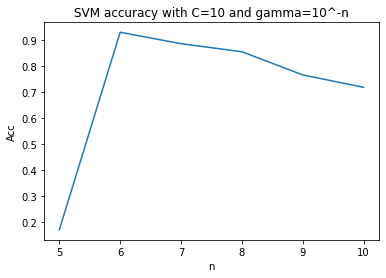

In [ ]:
plt.plot(gammas,res)
plt.title('SVM accuracy with C=10 and gamma=10^-n')
plt.xlabel('n')
plt.ylabel('Acc')

In [ ]:
preds = OVR(train_X,train_Y,test_X,classes,10,5e-6)

     pcost       dcost       gap    pres   dres
 0:  2.6131e+03 -5.6590e+04  6e+04  5e-13  1e-14
 1:  9.8747e+02 -8.2164e+03  9e+03  2e-13  9e-15
 2: -3.0971e+02 -1.1540e+03  8e+02  1e-13  3e-15
 3: -4.1917e+02 -4.8212e+02  6e+01  5e-14  7e-16
 4: -4.2110e+02 -4.2210e+02  1e+00  1e-15  1e-16
 5: -4.2112e+02 -4.2117e+02  5e-02  6e-15  9e-17
 6: -4.2112e+02 -4.2112e+02  3e-03  8e-15  7e-17
 7: -4.2112e+02 -4.2112e+02  1e-04  3e-16  8e-17
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  4.1952e+03 -4.5948e+04  5e+04  5e-12  1e-14
 1:  1.1345e+03 -7.2907e+03  8e+03  8e-13  9e-15
 2: -1.7430e+02 -1.0974e+03  9e+02  8e-14  3e-15
 3: -3.0974e+02 -3.8744e+02  8e+01  8e-14  1e-15
 4: -3.1343e+02 -3.1597e+02  3e+00  1e-14  3e-16
 5: -3.1349e+02 -3.1359e+02  1e-01  2e-14  2e-16
 6: -3.1350e+02 -3.1350e+02  3e-03  2e-15  1e-16
 7: -3.1350e+02 -3.1350e+02  1e-04  5e-15  1e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  2.7382e+03 -5.8129e

In [ ]:
train_X = mnist_train_data_uint8.astype('float32').reshape(-1, 28*28)[:10000]
train_Y = mnist_train_labels_int64[:10000]
classes = [i for i in range(10)]
test_X = mnist_test_data_uint8.astype('float32').reshape(-1, 28*28)
test_Y = mnist_test_labels_int64

In [ ]:
SVM_preds = OVR(train_X,train_Y,test_X,classes,10,1e-6)

     pcost       dcost       gap    pres   dres
 0:  1.1633e+04 -3.0981e+05  7e+05  3e-01  1e-14
 1:  9.8366e+03 -4.2073e+04  6e+04  2e-02  5e-15
 2:  2.8395e+03 -1.1688e+04  2e+04  4e-03  9e-15
 3:  1.9478e+02 -2.8371e+03  3e+03  4e-15  8e-15
 4: -2.9710e+02 -8.3350e+02  5e+02  1e-13  5e-15
 5: -3.6423e+02 -5.4015e+02  2e+02  8e-14  2e-15
 6: -3.8534e+02 -4.5684e+02  7e+01  2e-14  1e-15
 7: -3.9192e+02 -4.1613e+02  2e+01  2e-14  7e-16
 8: -3.9452e+02 -4.0228e+02  8e+00  2e-14  6e-16
 9: -3.9553e+02 -3.9768e+02  2e+00  5e-15  5e-16
10: -3.9585e+02 -3.9650e+02  6e-01  7e-15  5e-16
11: -3.9597e+02 -3.9611e+02  1e-01  2e-14  5e-16
12: -3.9600e+02 -3.9602e+02  2e-02  2e-14  5e-16
13: -3.9600e+02 -3.9600e+02  1e-03  2e-14  5e-16
14: -3.9600e+02 -3.9600e+02  2e-05  3e-14  5e-16
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  3.0685e+03 -2.4429e+05  6e+05  3e-01  1e-14
 1:  3.1343e+03 -2.5392e+04  4e+04  1e-02  8e-15
 2:  1.3280e+03 -6.3052e+03  9e+03  3e-03  9e-1

In [ ]:
np.mean(SVM_preds == mnist_test_labels_int64)

0.9644

In [ ]:
confusion_matrix(mnist_test_labels_int64,SVM_preds)

array([[ 966,    0,    2,    0,    0,    1,    7,    1,    3,    0],
       [   0, 1123,    3,    3,    1,    1,    3,    0,    1,    0],
       [   9,    0,  992,    5,    1,    0,    3,   10,   12,    0],
       [   0,    0,   13,  971,    0,    7,    1,    8,    8,    2],
       [   0,    0,    5,    0,  952,    0,    8,    1,    3,   13],
       [   5,    0,    8,   16,    1,  848,    7,    1,    5,    1],
       [   7,    3,    4,    0,    5,    2,  935,    0,    2,    0],
       [   1,    7,   22,    3,    4,    0,    0,  983,    0,    8],
       [   7,    0,   12,   15,    3,    3,    1,    4,  926,    3],
       [  11,    4,    3,    5,   20,    2,    1,    7,    8,  948]])

# Przełom w skuteczności klasyfikacji

<p align="center">
<img width="980" height="577" src="https://cdn.arstechnica.net/wp-content/uploads/2018/10/Screen-Shot-2018-10-12-at-4.24.35-PM.png">
</p>

(Źródło - https://arstechnica.com/science/2018/12/how-computers-got-shockingly-good-at-recognizing-images/)

Powyższa grafika pokazuje błąd najlepszego w danym roku modelu dla zbiru danych ImageNet.  
Warto zwrócić uwagę na spadek w latach 2012 oraz 2014.

<p align="center">
<img width="638" height="479" src="https://image.slidesharecdn.com/introtocnns-170414043209/95/intro-to-convolutional-neural-networks-13-638.jpg?cb=1492144489">
</p>

(Źródło - https://www.slideshare.net/MarkScully5/intro-to-convolutional-neural-networks)

# Regresja logistyczna




[Regresja liniowa i logistyczna](http://cs229.stanford.edu/notes/cs229-notes1.pdf)

Regresja logistyczna jest modelem, który dla każdej wartości wejściowej zwraca wartość wyjściową z przedziału $[0,1]$.  
Bardzo często wykorzystuje się ten fakt i stosuje się regresje logistyczną do klasyfikacji. Mając zbiór danych $X$ oraz ich klasy $Y$, gdzie $Y^i \in \{0,1\}$ możemy klasyfikować nowy wektor do klasy $1$, jeśli model dla tego wektora zwróci wartość bliską $1$. 



## Przypomnienie regresji liniowej

Mając dany wektor danych $x = [x_1,x_2,...,x_n]$ regresję liniową możemy opisać za pomocą wyrażenie
$$ h_\Theta(x) = \sum_{n=1}^N \Theta_n * x_n + \Theta_0 $$

Możemy więc przyjąć, że wektor danych x przekształcamy do postaci $x = [1,x_1,x_2,...,x_n]$, dzięki czemu powyższe równanie sprowadza się do:
$$h_\Theta(x) = \Theta^T x$$

## Sigmoid

Łatwo zauważyć, że wartości $h_\Theta(x)$ mogą przyjmować wartości z przedziału $(-\infty,\infty)$. Możemy jednak nałożyć na tą wartość sigmoid, czyli funkcję $\sigma(z) = \frac{1}{1+e^{-z}}$. Stąd:
$$h_\Theta(x) = \sigma(\Theta^T x) = \frac{1}{1+e^{-\Theta^T x}}$$


In [ ]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

Text(0.5, 1.0, 'Sigmoid')

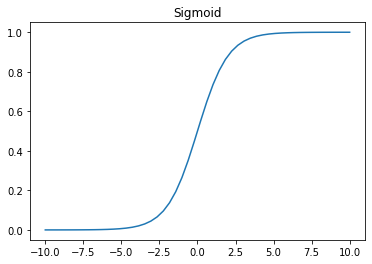

In [ ]:
X = np.linspace(-10,10)
plt.plot(X,sigmoid(X))
plt.title('Sigmoid')

Patrząc na powyższy wykres sigmoidu łatwo zauważyć, że $h_\Theta(x) \in [0,1]$.

## Funkcja straty

W pierwszym kroku możemy zastanowić się, jak wygląda pochodna dla sigmoidu.

$\begin{split} 
\sigma^{'}(x) & = & \frac{d}{dx} \frac{1}{1+e^{-x}}\\
& = & \frac{1}{(1+e^{-x})^2} e^{-x}& \\
& = & \frac{1}{1+e^{-x}} (1-\frac{1}{1+e^{-x}})\\
& = & \sigma(x) (1 - \sigma(x))
\end{split}$

Następnie możemy przyjąć, że wartość $h_\Theta(x)$ jest równa prawdopodobieństwu, że x ma klasę 1. Możemy to zapisać w postaci:

$$P(y=1|x;\Theta) = h_\Theta(x)$$
$$P(y=0|x;\Theta) = 1 - h_\Theta(x)$$

Łącząc te 2 wyrażenia i pamiętając, że $y \in \{0,1\}$ możemy wyprowadzić następującą zależność:

$$P(y|x;\Theta) = (h_\Theta(x))^y (1 - h_\Theta(x))^{1-y}$$

Następnie będziemy chcieli skorzystać z MLE (estymator największej wiarygodności). W tym celu potrzebujemy wyrażenia funkcji wiarygodności $L(\Theta)$, a dokładniej jej ujemną, zlogarytmowaną wartość nazywaną $nll(\Theta)$. 

$$
\begin{split}
nll(\Theta) &= -\sum_{i=1}^{N} y^{(i)} \log \sigma(\Theta^Tx^{(i)}) + (1-y^{(i)})\log(1-\sigma(\Theta^Tx^{(i)})) = \\
&= -\sum_{i=1}^{N}y^{(i)}\log p(y=1|x^{(i)}; \Theta) + (1-y^{(i)})\log  p(y=0|x^{(i)}; \Theta)
\end{split}
$$

Jest to często używana funkcja kosztu nazywana *cross-entropy loss function*.  
Czasem chcemy, by nasze parametry $\Theta$ nie przyjmowały zbyt dużej wartości, wtedy używamy regularyzacji i funkcja kosztu przyjmuje wartość:

\begin{split}
nll(\Theta) &= -\sum_{i=1}^{N}y^{(i)}\log p(y=1|x^{(i)}; \Theta) + (1-y^{(i)})\log  p(y=0|x^{(i)}; \Theta) + \frac{\lambda}{2} \sum_{i}\theta_{i}^{2}
\end{split}

## Gradient

Żeby znaleźć (wytrenować) odpowiednie parametry $\Theta$ musimy policzyć gradient funkcji straty ($nll(\Theta)$)

Policzmy początkowo gradient dla funkcji straty pojedynczego wektora, czyli $nll^{(i)}$.  
Niech $z^{(i)} = \Theta^Tx^{(i)}$. 
Korzystając z reguły łańcuchowej (chain rule) wiemy, że:
$$
\frac{\partial nll^{(i)}(\Theta)}{\partial \Theta} = \frac{\partial nll^{(i)}}{\partial z^{(i)}}\frac{\partial z^{(i)}}{\partial\Theta}
$$
Możemy więc wykonać te obliczenia w dwóch krokach.  

$$
\begin{split}
\frac{\partial nll^{(i)}}{\partial z^{(i)}} & = & \frac{\partial -\left(y^{(i)} \log \sigma(z^{(i)}) + (1-y^{(i)})\log(1-\sigma(z^{(i)}))\right)}{\partial z^{(i)}} \\
&=& -y^{(i)}\frac{\sigma(z^{(i)})(1-\sigma(z^{(i)}))}{\sigma(z^{(i)})} + 
(1-y^{(i)})\frac{\sigma(z^{(i)})(1-\sigma(z^{(i)}))}{1-\sigma(z^{(i)})} \\
&=& -y^{(i)}(1-\sigma(z^{(i)})) + (1-y^{(i)})\sigma(z^{(i)})\\
&=&\sigma(z^{(i)})-y^{(i)}\\
\\
\\
\frac{\partial z^{(i)}}{\partial\Theta} & = & \frac{\partial \Theta^Tx^{(i)}}{\partial\Theta} = x^{(i)}
\end{split}
$$

Stąd:
$$
\frac{\partial nll(\Theta)}{\partial \Theta} = \sum_{i=1}^{N}\frac{\partial nll^{(i)}}{\partial z^{(i)}}\frac{\partial z^{(i)}}{\partial\Theta} = \sum_{i=1}^{N}\left(\sigma(z^{(i)})-y^{(i)}\right)x^{(i)}
$$  

Powyższe wyrażenie możemy przedstawić w postaci:
$$
\frac{\partial nll(\Theta)}{\partial \Theta} = X\left(\sigma(Z)-Y\right)^T
$$

## Gradient descent (metoda gradientu prostego)

Gradient nie jest liniowo zależny od $\Theta$, więc znalezienie rozwiązania nie będzie takie proste, jak w przypadki regresji liniowej. Zamiast tego będziemy robić niewielkie kroki w kierunku gradientu tak długo, aż nie znajdziemy wystarczająco dobrego rozwiazanie.  
Nasz algorytm uczenia będzie miał więc postać:

1. $\Theta \leftarrow $ wartość początkowa 
2. while not bored:  
    $\Theta \gets \Theta - \alpha \frac{\partial L(\Theta)}{\partial\Theta}$

Gdzie $\alpha$ odpowiada za wielkość kroku, który robimy (zazwyczaj jest nazywana learning rate)

In [ ]:
class Logistic_Regression:
    def __init__(self, max_iter=500, solver_calls=5, lambda_=0.5, Theta=None, \
                 solver='l_bfgs_b', debug=False):
        self.Theta = Theta
        self.solver_calls = solver_calls
        self.max_iter = max_iter
        self.solver = solver
        self.debug = debug
        self.lambda_ = lambda_
    
    def __sigmoid(self,x):
        return 1 / (1 + np.exp(-x))   
    
    def __gradient(self,x,y,Theta):
        SZ = self.__sigmoid(np.dot(Theta,x.T))
        return np.dot(x.T, (y-SZ).T) + self.lambda_ * Theta
    
    def __hessian(self,x,y,Theta):
        SZ = self.__sigmoid(np.dot(Theta,x.T))
        hess = np.dot(x.T,x * (SZ).reshape(-1,1) * (1 - SZ).reshape(-1,1))
        hess += np.eye(hess.shape[0]) * self.lambda_
        return hess
    
    def __logreg_loss(self, Theta, X, Y):
        Theta = Theta.astype(np.float64)
        X = X.astype(np.float64)
        Y = Y.astype(np.float64)
        
        if self.debug:
            print(f"Loss calculating... ",end="")
        Z = np.dot(Theta,X.T)
        if self.debug:
            print(f" Z done... ",end="")
        SZ = self.__sigmoid(Z)
        Y_ = Y[:,np.newaxis]
        nll = -np.sum((Y_*np.log2(SZ+1e-50) + (1-Y_)*np.log2(1-SZ+1e-50)))
        nll += (self.lambda_/2) * np.sum(Theta**2)
        if self.debug:
            print(f" nll done... ",end="")
        grad = np.dot(X.T, (SZ - Y).T)
        grad = grad.reshape(Theta.shape) + self.lambda_ * Theta
        if self.debug:
            print(f" grad done... done ")
        return nll, grad
    
    
    def fit(self,X,y):
        if self.solver == 'l_bfgs_b':
            Theta = self.Theta
            if Theta is None:
                Theta = np.ones(X.shape[1]+1)

            X_with_ones = np.hstack((np.ones((X.shape[0],1)),X))

            for i in tqdm(range(self.solver_calls), desc='Calculating Theta', position=0):
                Theta = sopt.fmin_l_bfgs_b(lambda th: self.__logreg_loss(th, X_with_ones, y), 
                                    Theta, maxiter=self.max_iter)[0]
            self.Theta = Theta
            
        elif self.solver == 'newton':
            X_with_ones = np.hstack((np.ones((X.shape[0],1)),X))
            Theta = np.ones(X.shape[1]+1)
            g = self.__gradient(X_with_ones,y,Theta)
            i = 0
            while not np.all(np.isclose(g, 0, atol=0.00001)) and i < self.max_iter:
                hess_inv = np.linalg.inv(self.__hessian(X_with_ones, y, Theta))
                Theta = np.add(Theta, np.dot(hess_inv, g))
                g = self.__gradient(X_with_ones, y, Theta)
                i += 1
            self.Theta = Theta
        
        else:
            print(f'Wrong solver!: {self.solver}')
            

    def predict(self, X, threshold=0.5):
        X_with_ones = np.hstack((np.ones((X.shape[0],1)),X))
        preds = self.__sigmoid(np.dot(self.Theta, X_with_ones.T)) >= threshold
#         preds = np.dot(self.Theta, X_with_ones.T) >= 0
        return preds

# Sieć neuronowa

Sieć neuronowa jest zbudowana z wielu, połączonych ze sobą neuronów. 

<p align="center">
<img width="902" height="469" src="https://www.oracle.com/a/tech/img/art-neural-network-image001.png">
</p>

(Źródło - https://developer.oracle.com/databases/neural-network-machine-learning.html)

Spójrzmy jak wygląda i działa pojedyńczy neuron.  

<p align="center">
<img width="793" height="558" src="https://i.imgur.com/sBQSTpq.png">
</p>

(Źródło - https://github.com/janchorowski/dl_uwr/blob/summer2020/Lectures/01-intro.pdf)

Pojedynczy neuron zachowuje się tak samo, jak regresja logistyczna, co więcej, tak samo się go uczy. 


## Forward pass

<p align="center">
<img width="850" height="400" src="https://pvsmt99345.i.lithium.com/t5/image/serverpage/image-id/42338i09FC324A09ECA450/image-size/large?v=1.0&px=999">
</p>

<p align="center">
<img width="850" height="315" src="https://pvsmt99345.i.lithium.com/t5/image/serverpage/image-id/42339i8BA3F2CCCEDE7458?v=1.0">
</p>

(Źródło - https://community.alteryx.com/t5/Data-Science-Blog/It-s-a-No-Brainer-An-Introduction-to-Neural-Networks/ba-p/300479)

Każda kropka po lewej stronie odpowiada za jeden element wejścia, np. jeden piksel obrazu. Następnie każdy neuron z pierwszej warstwy oblicza swoją wartość w sposób pokazany na obrazku wyżej. Trzeba zwrócić uwagę, że każdy neuron ma osobną wagę dla każdego wejścia. Druga warstwa powtarza te same obliczenia, jedynie zamiast patrzeć na wejście (np. obraz) patrzy na wynik pierwszej warstwy. Ostatni warstwa ma dokładnie tylko neuronów, ile mamy możliwych klas. Ostatecznie wejście dostaje klasę, której odpowiadający neuron z ostatniej warstwy miał największą wartość. Takie przejście nazywa się forward passem. 


## Backward pass

<p align="center">
<img width="584" height="286" src="https://matthewmazur.files.wordpress.com/2018/03/output_1_backprop-4.png?w=584">
</p>

(Źródło - https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/)

By być w stanie uczyć sieć musimy potrafić policzyć gradienty. Możemy to zrobić przechodząc ponownie przez sieć, ale w przeciwnym kierunku. Jeśli skorzystamy kilkukrotnie z reguły łańcuchowej oraz wiemy, jakie obliczenia wykonują kolejny elementy sieci możemy z łatwością wyznaczyć, jaki wpływ na ostateczny wyniki (a dokładniej na funkcje straty) mają poszczególne wagi. Mając takie informacji wiemy jak zmienić każdą z wag w taki sposób, by nasza funkcja (najprawdopodobniej) była bliższa poprawnego wyniku.  

Większość bibliotek do sieci neuronowych wspiera takie obliczenia, zapamiętując kolejne etapy forward passu, dzięki czemu możemy otrzymać odpowiedni gradient nie wykonując samemu żadnych obliczeń.



## Uczenie sieci

Skoro pojedyncze neurony wykonują takie same obliczenia, jak regresja logistyczna, to ich uczenie również powinno być takie samo. I w praktyce w dużej części tak właśnie jest.


### Gradient descent

Musimy zdefiniować sobie funkcję straty, może to być opisywana wcześniej cross-entropy loss, ale dla prostoty możemy zastosować sumę kwadratów. Stąd:

$$L(\Theta) = \frac{1}{2} \sum_{i=0}^I(Net(x^{(i)},\Theta) - y^{(i)})^2$$

Czyli funkcja straty zależy od błędów popełnianych na wszystkich elementach zbioru treningowego.

Wówczas trening sieci wygląda tak samo, jak trening regresji logistycznej, czyli:

1. $\Theta \leftarrow $ wartość początkowa 
2. while not bored:  
    $\Theta \gets \Theta - \alpha \frac{\partial L(\Theta)}{\partial\Theta}$

Gdzie $\alpha$ odpowiada za wielkość kroku, który robimy (zazwyczaj jest nazywana learning rate)

### Stochastic gradient descent

W praktyce często stosuje się inną, chociaż podobną metodę. Zamiast obliczać błąd dla wszystkich elementów zbioru treningowego, a następnie jednokrotnie aktualizować parametry możemy aktualizować parametry po każdym elemencie, na podstawie błędu na nim popełnionego. Taką metodę nazywamy stochastic gradient descent (metoda gradientu stochastycznego). 

1. $\Theta \leftarrow $ wartość początkowa 
2. while not bored:  
    for i = 0...I: \\
    $\quad \Theta \gets \Theta - \alpha \frac{\partial L^{(i)}(\Theta)}{\partial\Theta}$

Zalety takiej metody to szybkość oraz łatwiejsza implementacji dla bardzo dużych danych, które nie mieszczą się w RAM`ie.  

W przypadku SGD należy zwrócić szczególną uwagę na dobór parametru $\alpha$. W praktyce po każdym kroku parametry będą chciały zmieniać się w taki sposób, by zminimalizować błąd dla tego jednego elementu. Learning rate nie może być więc zbyt duży, by nie "wyskoczyć" z optymalnego obszaru oraz wystarczająco duży, by powoli poprawiać skuteczność sieci.  

<p align="center">
<img width="600" height="200" src="https://cdn-images-1.medium.com/max/1000/1*An4tZEyQAYgPAZl396JzWg.png">
</p>

(Źródło - https://mc.ai/cyclical-learning-rates-for-training-neural-networks/)

W praktyce używa się wielu metod doboru oraz zmiany parametru $\alpha$ (np. $\alpha$ schedule).

In [ ]:
def compute_error_rate(model, data_loader, device='cpu'):
    """Evaluate model on all samples from the data loader.
    """
    # Put the model in eval mode, and move to the evaluation device.
    model.eval()
    model.to(device)
    if isinstance(data_loader, InMemDataLoader):
        data_loader.to(device)
    
    num_errs = 0.0
    num_examples = 0
    # we don't need gradient during eval!
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            y = y.to(device)
            outputs = model.forward(x)
            _, predictions = outputs.data.max(dim=1)
            num_errs += (predictions != y.data).sum().item()
            num_examples += x.size(0)
    return num_errs / num_examples

def plot_history(history):
    """Helper to plot the trainig progress over time."""
    plt.figure(figsize=(16, 4))
    plt.subplot(1,2,1)
    train_loss = np.array(history['train_losses'])
    plt.semilogy(np.arange(train_loss.shape[0]), train_loss, label='batch train loss')
    plt.legend()
        
    plt.subplot(1,2,2)
    train_errs = np.array(history['train_errs'])
    alpha = np.array(history['alpha'])
    plt.plot(np.arange(train_errs.shape[0]), train_errs, label='batch train error rate')
    val_errs = np.array(history['val_errs'])
    plt.plot(val_errs[:,0], val_errs[:,1], label='validation error rate', color='r')
    plt.plot(alpha[:,0], alpha[:,1], label = 'alpha')
    plt.ylim(0, 0.20)
    plt.legend()

In [ ]:
class InMemDataLoader(object):
    """
    A data loader that keeps all data in CPU or GPU memory.
    """
    __initialized = False
    def __init__(self, dataset, batch_size=1, shuffle=False, sampler=None,
                 batch_sampler=None, drop_last=False):
        """A torch dataloader that fetches data from memory."""
        batches = []
        for i in tqdm(range(len(dataset))):
            batch = [torch.tensor(t) for t in dataset[i]]
            batches.append(batch)
        tensors = [
            torch.stack(ts) for ts in zip(*batches)
        ]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last
        
        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError('batch_sampler option is mutually exclusive '
                                 'with batch_size, shuffle, sampler, and '
                                 'drop_last')
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError('sampler option is mutually exclusive with '
                             'shuffle')
            
        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(sampler, batch_size, drop_last)

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True
    
    def __setattr__(self, attr, val):
        if self.__initialized and attr in ('batch_size', 'sampler', 'drop_last'):
            raise ValueError('{} attribute should not be set after {} is '
                             'initialized'.format(attr, self.__class__.__name__))

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)
    
    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

In [ ]:
batch_size = 128
data_path = './data'

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ])

_test = torchvision.datasets.MNIST(
    data_path, train=False, download=True, transform=transform)

# Load training data, split into train and valid sets
_train = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform)
_train.data = _train.data[:50000]
_train.targets = _train.targets[:50000]

_valid = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform)
_valid.data = _valid.data[50000:]
_valid.targets = _valid.targets[50000:]

mnist_loaders = {
    'train': InMemDataLoader(
        _train, batch_size=batch_size, shuffle=True),
    'valid': InMemDataLoader(
        _valid, batch_size=batch_size, shuffle=False),
    'test': InMemDataLoader(
        _test, batch_size=batch_size, shuffle=False)}

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!






/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
def SGD(model, data_loaders, 
        alpha=1e-4, epsilon=0.0, decay=0.0, 
        nesterov_momentum = False, alpha_schedule = 0, epsilon_schedule = 0,
        alpha_schedule_value = 0.95, epsilon_schedule_value = 0.95,
        num_epochs=1, max_num_epochs=np.nan, patience_expansion=1.5,
        log_every=100, device='cpu'):
    
    # Put the model in train mode, and move to the evaluation device.
    model.train()
    model.to(device)
    for data_loader in data_loaders.values():
        if isinstance(data_loader, InMemDataLoader):
            data_loader.to(device)


    # Different types of velocities initialization (zeros works better for me)

    velocities = [torch.zeros(p.size(),device=device) for p in model.parameters()]
    # velocities = [0.1 * torch.randn(p.size(),device=device) if 'weight' in name\
    #              else torch.zeros(p.size(),device=device) for (name, p) in model.named_parameters()]

    
    iter_ = 0
    epoch = 0
    best_params = None
    best_val_err = np.inf
    history = {'train_losses': [], 'train_errs': [], 'val_errs': [], 'alpha': []}
    print('Training the model!')
    print('Interrupt at any time to evaluate the best validation model so far.')

    try:
        tstart = time.time()
        siter = iter_
        while epoch < num_epochs:
            model.train()
            epoch += 1
            if epoch > max_num_epochs:
                break

            # different combinations of lerning rate control

            if alpha_schedule == 1:
                alpha *= alpha_schedule_value
            elif alpha_schedule == 2:
                if not epoch%5 and epoch:
                    alpha /= 2
            elif alpha_schedule == 3:
                alpha *= alpha_schedule_value
                if not epoch%10 and epoch:
                    alpha *= (0.9 / (alpha_schedule_value**10))
                
            if epsilon_schedule == 1:
                epsilon *= epsilon_schedule_value

            for x, y in data_loaders['train']:
                x = x.to(device)
                y = y.to(device)
                iter_ += 1
                # This calls the `forward` function: https://pytorch.org/tutorials/beginner/examples_nn/two_layer_net_module.html
                out = model(x)
                loss = model.loss(out, y)
                loss.backward()
                _, predictions = out.max(dim=1)
                batch_err_rate = (predictions != y).sum().item() / out.size(0)

                history['train_losses'].append(loss.item())
                history['train_errs'].append(batch_err_rate)
                history['alpha'].append((iter_,alpha))
                
                # disable gradient computations - we do not want torch to
                # backpropagate through the gradient application!
                with torch.no_grad():
                    for (name, p), v in zip(model.named_parameters(),
                                            velocities):
                        if 'weight' in name:
                            p.grad += 2 * decay * p

                        if nesterov_momentum:
                            # Nesterov momentum: 
                            v_prev = v[...]
                            v[...] = epsilon * v - alpha * p.grad
                            p += - epsilon * v_prev + (1 + epsilon) * v
                        else:
                            # Momentum
                            v[...] = epsilon*v -  alpha*p.grad
                            p += v
                        
                        # Zero gradients for the next iteration
                        p.grad.zero_()

                if iter_ % log_every == 0:
                    num_iter = iter_ - siter + 1
                    print("Minibatch {0: >6}  | loss {1: >5.2f} | err rate {2: >5.2f}%, steps/s {3: >5.2f}" \
                          .format(iter_, loss.item(), batch_err_rate * 100.0, num_iter / (time.time() - tstart)))
                    tstart = time.time()
                           
            
            val_err_rate = compute_error_rate(model, data_loaders['valid'], device)
            history['val_errs'].append((iter_, val_err_rate))
            
            if val_err_rate < best_val_err:
                # Adjust num of epochs
                num_epochs = int(np.maximum(num_epochs, epoch * patience_expansion + 1))
                best_epoch = epoch
                best_val_err = val_err_rate
                best_params = [p.detach().cpu() for p in model.parameters()]
            clear_output(True)
            m = "After epoch {0: >2} | valid err rate: {1: >5.2f}% | doing {2: >3} epochs" \
                .format(epoch, val_err_rate * 100.0, num_epochs)
            print('{0}\n{1}\n{0}'.format('-' * len(m), m))

    except KeyboardInterrupt:
        pass

    if best_params is not None:
        print("\nLoading best params on validation set (epoch %d)\n" %(best_epoch))
        with torch.no_grad():
            for param, best_param in zip(model.parameters(), best_params):
                param[...] = best_param
    plot_history(history)

----------------------------------------------------------
After epoch 30 | valid err rate:  1.63% | doing  50 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 26)

-------------------------------------------
Test error rate: 1.720%, training took 34s.
-------------------------------------------


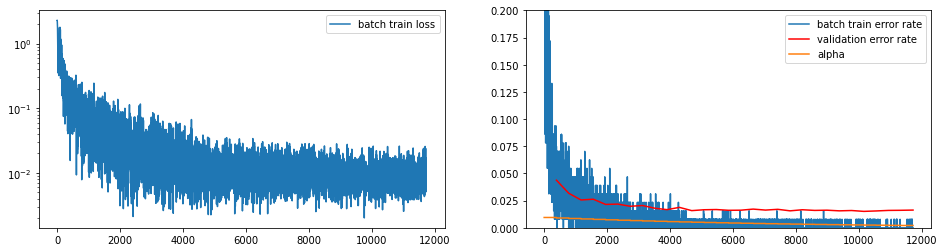

In [ ]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Model, self).__init__()
        self.layers = nn.Sequential(*args, **kwargs)

    def forward(self, X):
        X = X.view(X.size(0), -1)
        return self.layers.forward(X)
    
    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)

model = Model(
    nn.Linear(28*28,1000),
    nn.ReLU(),
    nn.Linear(1000, 10)
    )

with torch.no_grad():
    # Initialize parameters
    for name, p in model.named_parameters():
        if 'weight' in name:
            p.normal_(0, 0.01)
        elif 'bias' in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

# On GPU enabled devices set device='cuda' else set device='cpu'

t_start = time.time()
SGD(model, mnist_loaders, alpha=0.01, epsilon=0.99, decay=0.00025, \
    nesterov_momentum = False, alpha_schedule = 1,epsilon_schedule = 0, \
    alpha_schedule_value = 0.95, epsilon_schedule_value = 0.95,\
    patience_expansion=1.9, max_num_epochs=30, device='cuda')


test_err_rate = compute_error_rate(model, mnist_loaders['test'])
m = (f"Test error rate: {test_err_rate * 100.0:.3f}%, "
     f"training took {time.time() - t_start:.0f}s.")
print('{0}\n{1}\n{0}'.format('-' * len(m), m))

# Sieć razem z SGD pochodzi z ćwiczeń z Deep Learning

# Sieci splotowe (Convolutional network)

## Warstwa splotowa

[ConvNets](https://cs231n.github.io/convolutional-networks/)

<p align="center">
<img width="400" height="450" src="https://miro.medium.com/max/790/1*nYf_cUIHFEWU1JXGwnz-Ig.gif">
</p>

(Źródło - https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

W sieciach splotowych (konwolucyjnych) pojedynczy neuron zamiast "patrzeć" na każdy piksel patrzy jedynie na pewien wycinek obrazu wejściowego. Jeśli obraz ma 3 kanały (R-G-B) wówczas pojedynczy piksel bierze informacje ze wszystkich kanałów w tym obszarze. 
Co więcej wszystkie piksele w danym kanale współdzielą między sobą wagi, chociaż patrzą na inne obszary. 

W danej warstwie tworzy się zazwyczaj więcej niż jeden kanał. Wtedy dla każdego obszaru mamy kilka pikseli, które na nie patrzą. Każdy z tych pikseli ma własne wagi, wagi te są współdzielone w danym kanale, ale nie między nimi. 

<p align="center">
<img width="400" height="250" src="https://cs231n.github.io/assets/cnn/depthcol.jpeg">
</p>

(Źródło - https://cs231n.github.io/convolutional-networks/)

---

<p align="center">
<img width="800" height="700" src="https://i.imgur.com/M2meGA4.png">
</p>

(Źródło - https://cs231n.github.io/convolutional-networks/)




## Pooling

<p align="center">
<img width="800" height="300" src="https://i.imgur.com/uy3JY3j.png">
</p>

(Źródło - https://cs231n.github.io/convolutional-networks/)

Pooling polega na zmiejszeniu wymiarowości w ten sposób, że patrzymy na obszar o pewnym rozmiarze i dla każdego rozpatrywanu obszaru zapisujemy min/max/avg z wartości w tym obszarze. 

<p align="center">
<img width="400" height="250" src="https://www.cntk.ai/jup/c103d_max_pooling.gif">
</p>

(Źródło - https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)


## Conv + Pool

<p align="center">
<img width="900" height="300" src="https://miro.medium.com/max/2000/1*vkQ0hXDaQv57sALXAJquxA.jpeg">
</p>

(Źródło - https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

W praktyce stosuje się wiele warstw conv + pool jedna po drugiej, przeplatając je funkcjami nieliniowymi, jak np. ReLu. Na końcu stosuje się warstwy w pełni połączone, czyli takie, jak w prostych sieciach opisywanych na początku. 



In [ ]:
class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, 5, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 5, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        self.linear = nn.Sequential(
            nn.Dropout(),
            nn.Linear(32*5*5, 500),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(500, 10)
            )

    def forward(self, X):
        out = self.conv(X)
        out = out.reshape(out.size(0), -1)
        out = self.linear(out)
        return out
    
    def loss(self, Out, Targets):
        return F.cross_entropy(Out, Targets)

----------------------------------------------------------
After epoch 75 | valid err rate:  0.64% | doing 129 epochs
----------------------------------------------------------

Loading best params on validation set (epoch 64)

--------------------------------------------
Test error rate: 0.620%, training took 213s.
--------------------------------------------


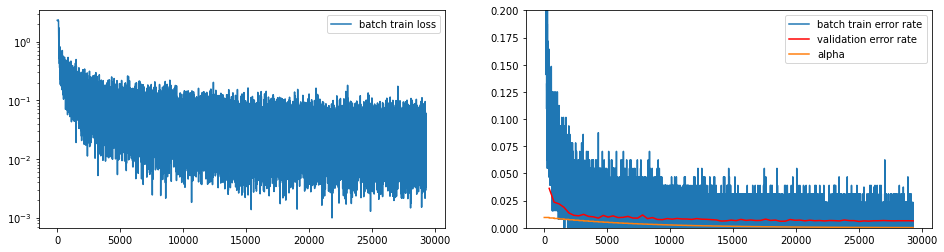

In [ ]:
model = ConvModel()

with torch.no_grad():
    # Initialize parameters
    for name, p in model.named_parameters():
        if 'weight' in name:
            p.normal_(0, 0.01)
        elif 'bias' in name:
            p.zero_()
        else:
            raise ValueError('Unknown parameter name "%s"' % name)

# On GPU enabled devices set device='cuda' else set device='cpu'

t_start = time.time()
SGD(model, mnist_loaders, alpha=0.01, epsilon=0.99, decay=0.0005, \
    nesterov_momentum = False, alpha_schedule = 1, epsilon_schedule = 0, \
    alpha_schedule_value = 0.95, epsilon_schedule_value = 0.95,\
    patience_expansion=2.0, max_num_epochs=75, device='cuda')


test_err_rate = compute_error_rate(model, mnist_loaders['test'])
m = (f"Test error rate: {test_err_rate * 100.0:.3f}%, "
     f"training took {time.time() - t_start:.0f}s.")
print('{0}\n{1}\n{0}'.format('-' * len(m), m))

# ConvNet pochodzi z ćwiczeń z Deep Learningu

## Rezultat

<p align="center">
<img width="1270" height="1690" src="https://i.stack.imgur.com/h8YGK.jpg">
</p>

(Źródło - https://ai.stackexchange.com/questions/20167/understanding-the-results-of-visualizing-and-understanding-convolutional-networ)

# Wykrywanie obiektów 

W celu wykrycia, czy w danym miejscu zdjęcia znajduje się jakiś obiekt (i ewentualnie jaki to jest obiekt) moglibyśmy zastosować prosty, ale bardzo nieefektywny algorytm polegający na próbie klasyfikacji każdego fragmentu obrazu o wszystkich możliwych rozmiarach. Powstało jednak wiele metod pozwalających rozwiązać ten problem w bardziej efektywny sposób.


## Fast R-CNN

<p align="center">
<img width="700" height="700" src="https://jkjung-avt.github.io/assets/2018-03-30-making-frcn-faster/FRCN_architecture.png">
</p>

(Źródło - https://jkjung-avt.github.io/making-frcn-faster/)

Fast R-CNN polega na zastosowaniu kilku warstw konwolucyjnych w celu uzyskania mapy obiektów / cech. Nie stosujemy jednak warstw liniowych, co zrobilibyśmy w celu uzyskania predykcji co znajduje się na obrazku. Zamiast tego przyglądamy się miejscom, w których feature-map ma dużą wartość, ponieważ podejrzewamy, że to właśnie tam mogą znajdować się jakieś obiekty. Następnie dla wszystkich tych miejscu staramy się (również za pomocą sieci) określić czy coś się tam faktycznie znajduje, jak duże to jest oraz czym jest ten obiekt.

<p align="center">
<img width="900" height="240" src="https://i0.wp.com/kitflix.com/wp-content/uploads/2019/11/fast.png">
</p>

(Źródło - https://kitflix.com/faster-rcnnn-machine-learning-algorithm/)



## YOLO (you only look once)

<p align="center">
<img width="600" height="381" src="https://pyimagesearch.com/wp-content/uploads/2018/11/yolo_design.jpg">
</p>

(Źródło - https://www.pyimagesearch.com/2018/11/12/yolo-object-detection-with-opencv/)

Inną, mniej skuteczną, ale dużo szybszą metodą jest YOLO. Ona również wykorzystuje sieci splotowe, ale zamiast wybierać obszary, które są dla nas potencjalne interesujące, a następnie ich dalszą analizę stawia ona na inne podejście. Po stworzeniu features map dla każdego elementu tej mapy sieć próbuje dokonać predykcji, czy w danym miejscu znajduje się (a dokładniej zaczyna się) jakiś obiekt oraz jak duży on jest. Dla każdego piksela można również dokonać predykcji klasy. Łącząc te informacje wybieramy kilka pikseli o najbardziej pewnych predykcjach i na tej podstawie tworzymy wynikową detekcję.  
Metoda ta jest bardzo szybka (ale nie jest najskuteczniejsza), dzięki czemu jest wykorzystywana tam, gdzie konieczna jest praca w czasie rzeczywistym. 

# Źródła

Materiały z których korzystałem zostały umieszczone jako odnośniki do danych tematów.  
Oprócz nich korzystałem z wykładów do Machine Learning oraz Deep Learning autorstwa Doktora Jana Chorowskiego.

Źródła wszystkich grafik znajdują się pod nimi.  

Część kodu pochodziła z ćwiczeń z Machine Learningu, Deep Learningu oraz z moich projektów realizowanych w czasie studiów.
